# Reto 2 — Ingeniería de Datos con Pandas (NYC Taxi Trip Duration)
**Diplomado en Estrategias de Datos - USTA**

- **Estudiante:** Janis Rodriguez  
- **Fecha:** 2026-01-05

**Objetivo:** Demostrar prácticas profesionales de *Ingeniería de Datos* con Pandas sobre un dataset real (≈1.4M filas):  
1) Medición inicial de memoria, 2) optimización (≥50%), 3) ingeniería de variables **vectorizada** (sin loops por fila), 4) visualización con narrativa, y 5) generación automática de un **reporte PDF**.


In [18]:
# =============================================================================
# 0) Setup
# =============================================================================
import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# Para PDF
from fpdf import FPDF
from datetime import datetime

pd.set_option("display.max_columns", 200)
np.random.seed(42)

# Carpetas de salida
OUT_DIR = Path("reportes")
G_DIR = OUT_DIR / "graficos"
OUT_DIR.mkdir(parents=True, exist_ok=True)
G_DIR.mkdir(parents=True, exist_ok=True)

print("OK ✅")

OK ✅


# 1) Localizar el archivo `train.csv`
Para evitar errores típicos de ruta (ej. abrir Jupyter desde otra carpeta), definimos una función que busca el archivo en rutas comunes.

In [19]:
def find_train_csv() -> Path:
    candidates = [
        Path("data/raw/train.csv"),
        Path("data/train.csv"),
        Path("train.csv"),
    ]
    for p in candidates:
        if p.exists():
            return p.resolve()
    raise FileNotFoundError(f"No encontré train.csv en: {candidates}")

TRAIN_PATH = find_train_csv()
TRAIN_PATH


PosixPath('/app/data/raw/train.csv')

## A) Medición inicial (baseline) y diagnóstico de memoria (deep)

Primero cargamos el dataset **sin optimizar** para medir el consumo real de memoria (`deep=True`).  
Esto nos da el punto de martida para demostrar que podemos reducir **≥50%** con buenas prácticas de tipos.

In [20]:
print("="*80)
print("A1) CARGA BASELINE (SIN OPTIMIZAR)")
print("="*80)

# ⚠️ Si tu PC es limitada de RAM, este paso puede tardar o lanzar MemoryError.
# Lo ideal (para el reto) es cargar completo. Aun así, dejamos un fallback controlado.
try:
    df_raw = pd.read_csv(TRAIN_PATH)
    baseline_loaded = True
except MemoryError:
    baseline_loaded = False
    df_raw = pd.read_csv(TRAIN_PATH, nrows=300_000)
    print("⚠️ MemoryError: se cargó una muestra (300k filas).")
    print("   Para cumplir el reto al 100%, ejecuta en un equipo con más RAM o usa lectura optimizada (A2).")

print("Shape:", df_raw.shape)
df_raw.head()

A1) CARGA BASELINE (SIN OPTIMIZAR)
Shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [21]:
print("="*80)
print("A1.1) MEMORIA (ANTES) — deep=True")
print("="*80)

mem_before_mb = df_raw.memory_usage(deep=True).sum() / 1024**2
print(f"Memoria total (ANTES): {mem_before_mb:,.2f} MB")

mem_by_col_before = (df_raw.memory_usage(deep=True) / 1024**2).sort_values(ascending=False)
mem_by_col_before.head(12)

A1.1) MEMORIA (ANTES) — deep=True
Memoria total (ANTES): 417.32 MB


pickup_datetime       94.592850
dropoff_datetime      94.592850
id                    80.682137
store_and_fwd_flag    69.553566
pickup_latitude       11.128571
vendor_id             11.128571
pickup_longitude      11.128571
passenger_count       11.128571
dropoff_latitude      11.128571
dropoff_longitude     11.128571
trip_duration         11.128571
Index                  0.000126
dtype: float64

## A2) Optimización profesional de tipos (target ≥50%)

Estrategia (sin perder información):
- **Enteros:** `int64 → int8/int16/int32` según rangos (*downcast*)
- **Flotantes:** `float64 → float32`
- **Categorías:** `object → category` cuando hay pocos valores únicos (ej. banderas)
- **Fechas:** convertir a `datetime64[ns]` (reduce uso vs string + habilita `.dt`)

Además, para demostrar ingeniería, incluimos **lectura optimizada**: cargar el CSV ya con `dtype` y `parse_dates`.

In [22]:
def optimize_types(df: pd.DataFrame) -> pd.DataFrame:
    df_opt = df.copy()

    # 1) Datetimes
    for col in ["pickup_datetime", "dropoff_datetime"]:
        if col in df_opt.columns:
            df_opt[col] = pd.to_datetime(df_opt[col], errors="coerce")

    # 2) Downcast ints
    int_cols = df_opt.select_dtypes(include=["int64", "int32", "int16"]).columns
    for col in int_cols:
        df_opt[col] = pd.to_numeric(df_opt[col], downcast="integer")

    # 3) Downcast floats
    float_cols = df_opt.select_dtypes(include=["float64"]).columns
    for col in float_cols:
        df_opt[col] = pd.to_numeric(df_opt[col], downcast="float")

    # 4) object -> category cuando aplica
    # Evitamos la columna 'id' (casi única) porque category no ahorra ahí.
    for col in df_opt.select_dtypes(include=["object"]).columns:
        if col.lower() == "id":
            continue
        nunique = df_opt[col].nunique(dropna=False)
        ratio = nunique / max(len(df_opt), 1)
        # umbral: <=5% valores únicos sobre total
        if ratio <= 0.05:
            df_opt[col] = df_opt[col].astype("category")

    return df_opt

df_opt = optimize_types(df_raw)

mem_after_mb = df_opt.memory_usage(deep=True).sum() / 1024**2
reduction_pct = (mem_before_mb - mem_after_mb) / mem_before_mb * 100

print("="*80)
print("A2) RESULTADO OPTIMIZACIÓN")
print("="*80)
print(f"Memoria ANTES : {mem_before_mb:,.2f} MB")
print(f"Memoria DESPUÉS: {mem_after_mb:,.2f} MB")
print(f"Reducción     : {reduction_pct:,.1f}%")
print("✅ Meta ≥50% alcanzada" if reduction_pct >= 50 else "⚠️ Meta NO alcanzada todavía (ver A2.1)")

df_opt.dtypes

A2) RESULTADO OPTIMIZACIÓN
Memoria ANTES : 417.32 MB
Memoria DESPUÉS: 134.93 MB
Reducción     : 67.7%
✅ Meta ≥50% alcanzada


id                            object
vendor_id                       int8
pickup_datetime       datetime64[ns]
dropoff_datetime      datetime64[ns]
passenger_count                 int8
pickup_longitude             float32
pickup_latitude              float32
dropoff_longitude            float32
dropoff_latitude             float32
store_and_fwd_flag          category
trip_duration                  int32
dtype: object

## A3) Validación de integridad (sin perder info)

Validamos que el número de filas sea el mismo y revisamos nulos.  
*(En un pipeline real también validaríamos checksums, reglas de negocio, etc.)*

In [23]:
print("="*80)
print("A3) VALIDACIÓN BÁSICA")
print("="*80)

print("Filas baseline:", len(df_raw))
print("Filas optimizado:", len(df_opt))

nulls = df_opt.isna().sum().sort_values(ascending=False).head(10)
nulls


A3) VALIDACIÓN BÁSICA
Filas baseline: 1458644
Filas optimizado: 1458644
A3) VALIDACIÓN BÁSICA
Filas baseline: 1458644
Filas optimizado: 1458644


id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64

## B) Ingeniería de variables vectorizada (sin loops por fila)

Creamos variables **temporales**, **duración** y **geoespaciales** usando `.dt`, `numpy` y operaciones vectorizadas.  
Esto escala miles de veces mejor que iterar fila a fila.

In [24]:
# Trabajaremos desde df_read_opt si existe y cargó completo, si no df_opt.
df = df_read_opt.copy() if "df_read_opt" in globals() else df_opt.copy()

print("Usando df con shape:", df.shape)
df.head(3)

Usando df con shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124


In [25]:
# =============================================================================
# B1) Variables temporales
# =============================================================================
df = df.assign(
    pickup_hour=df["pickup_datetime"].dt.hour.astype("int8"),
    pickup_dayofweek=df["pickup_datetime"].dt.dayofweek.astype("int8"),  # 0=Lun ... 6=Dom
    pickup_month=df["pickup_datetime"].dt.month.astype("int8"),
    is_weekend=df["pickup_datetime"].dt.dayofweek.isin([5, 6]).astype("int8"),
)

# =============================================================================
# B2) Variables de duración
# =============================================================================
df = df.assign(
    trip_duration_minutes=(df["trip_duration"] / 60).astype("float32"),
    trip_duration_log=np.log1p(df["trip_duration"]).astype("float32"),
)

# bins (queda como category)
df["duration_bin"] = pd.cut(
    df["trip_duration_minutes"],
    bins=[0, 5, 10, 20, 30, 60, np.inf],
    labels=["0-5", "5-10", "10-20", "20-30", "30-60", ">60"],
).astype("category")

df[["pickup_hour", "pickup_dayofweek", "pickup_month", "is_weekend", "trip_duration_minutes", "duration_bin"]].head()

,pickup_hour,pickup_dayofweek,pickup_month,is_weekend,trip_duration_minutes,duration_bin
0,17,0,3,0,7.583333,5-10
1,0,6,6,1,11.050000,10-20
2,11,1,1,0,35.400002,30-60
3,19,2,4,0,7.150000,5-10
4,13,5,3,1,7.250000,5-10


In [26]:
# =============================================================================
# B3) Haversine vectorizado (distancia km) + velocidad aproximada (km/h)
# =============================================================================
def haversine_km(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return 6371.0 * c

df["distance_km"] = haversine_km(
    df["pickup_latitude"].to_numpy(),
    df["pickup_longitude"].to_numpy(),
    df["dropoff_latitude"].to_numpy(),
    df["dropoff_longitude"].to_numpy(),
).astype("float32")

# Evitar división por 0 y valores infinitos
duration_hours = (df["trip_duration"].to_numpy() / 3600.0)
speed = df["distance_km"].to_numpy() / np.where(duration_hours == 0, np.nan, duration_hours)
df["approx_speed_kmh"] = pd.Series(speed).replace([np.inf, -np.inf], np.nan).astype("float32")

df[["distance_km", "approx_speed_kmh"]].describe().T

,count,mean,std,min,25%,50%,75%,max
distance_km,1458644.0,3.440864,4.296538,0.0,1.231838,2.093705,3.875308,1240.908813
approx_speed_kmh,1458644.0,14.423211,14.977631,0.0,9.121308,12.791970,17.845131,9274.967773


## C) Visualización Pro (Storytelling)

Reglas aplicadas:
- **Control de sesgo:** distribuciones sesgadas en **escala log**
- **Overplotting:** mapas/scatters con **hexbin** o muestreo
- **Chartjunk:** títulos claros, ejes legibles, sin ruido innecesario
- **Narrativa:** cada gráfico responde una pregunta

In [53]:
# Para gráficos pesados, trabajamos con una muestra (manteniendo el análisis completo en df)
SAMPLE_N = 200_000 if len(df) > 200_000 else len(df)
df_s = df.sample(SAMPLE_N, random_state=42) if SAMPLE_N < len(df) else df

print("Muestra para viz:", df_s.shape)

Muestra para viz: (200000, 20)


### C1) ¿Cómo se distribuye la duración de los viajes? (sesgo + escala log)

La duración suele ser **altamente sesgada**: muchos viajes cortos y pocos viajes extremadamente largos (outliers).  
Comparamos escala normal vs transformación `log1p`.

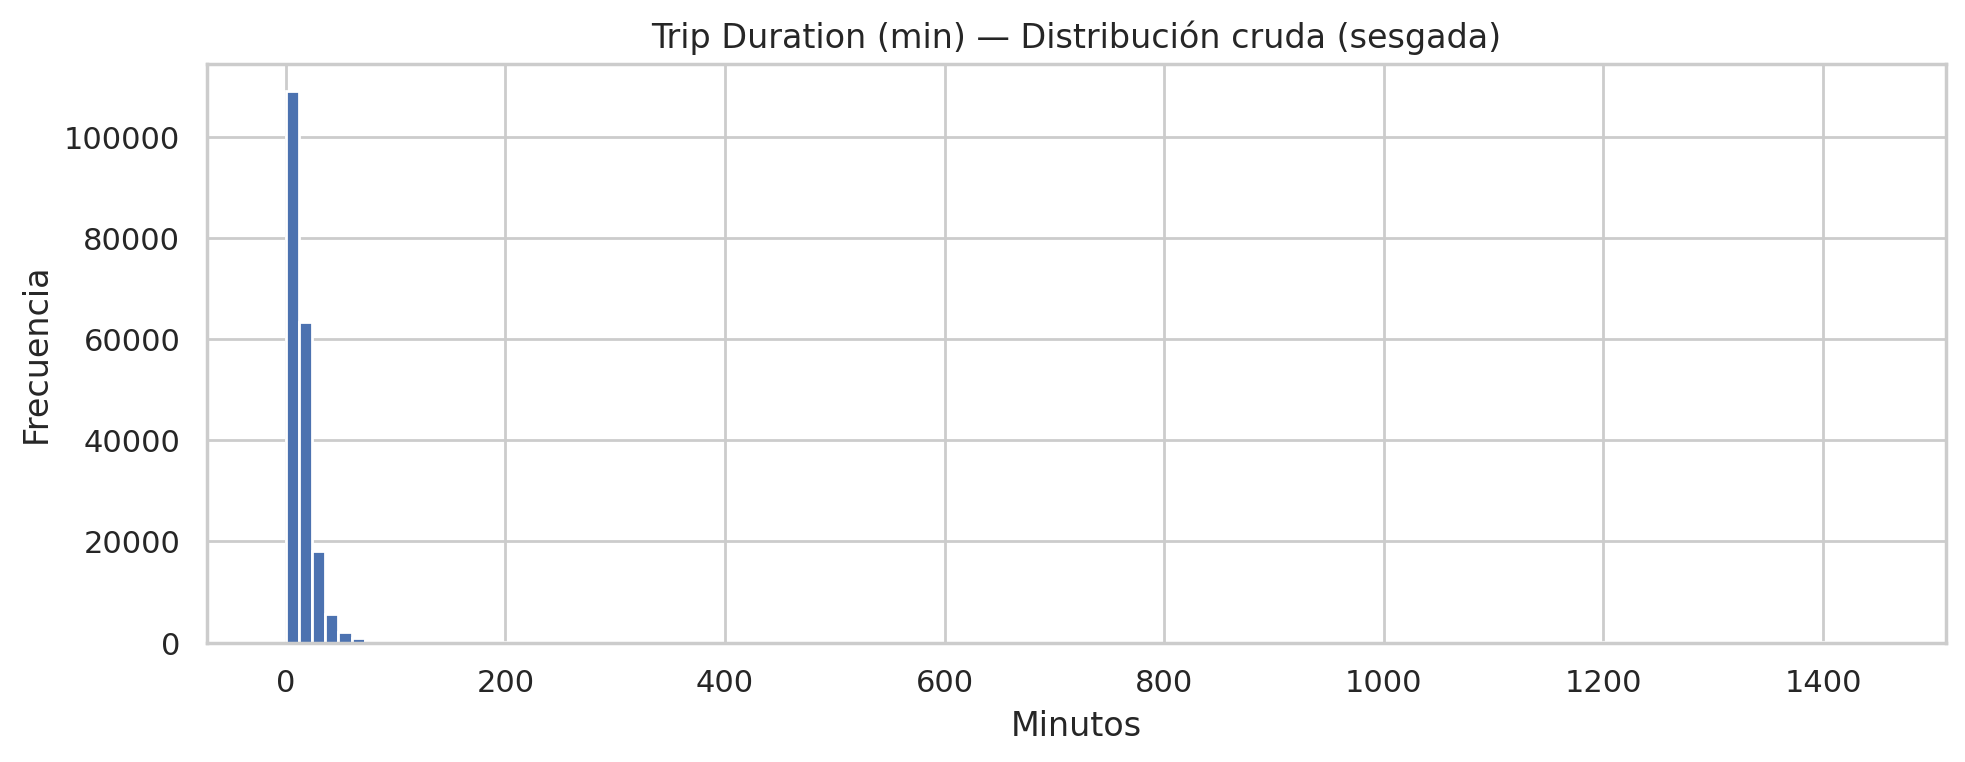

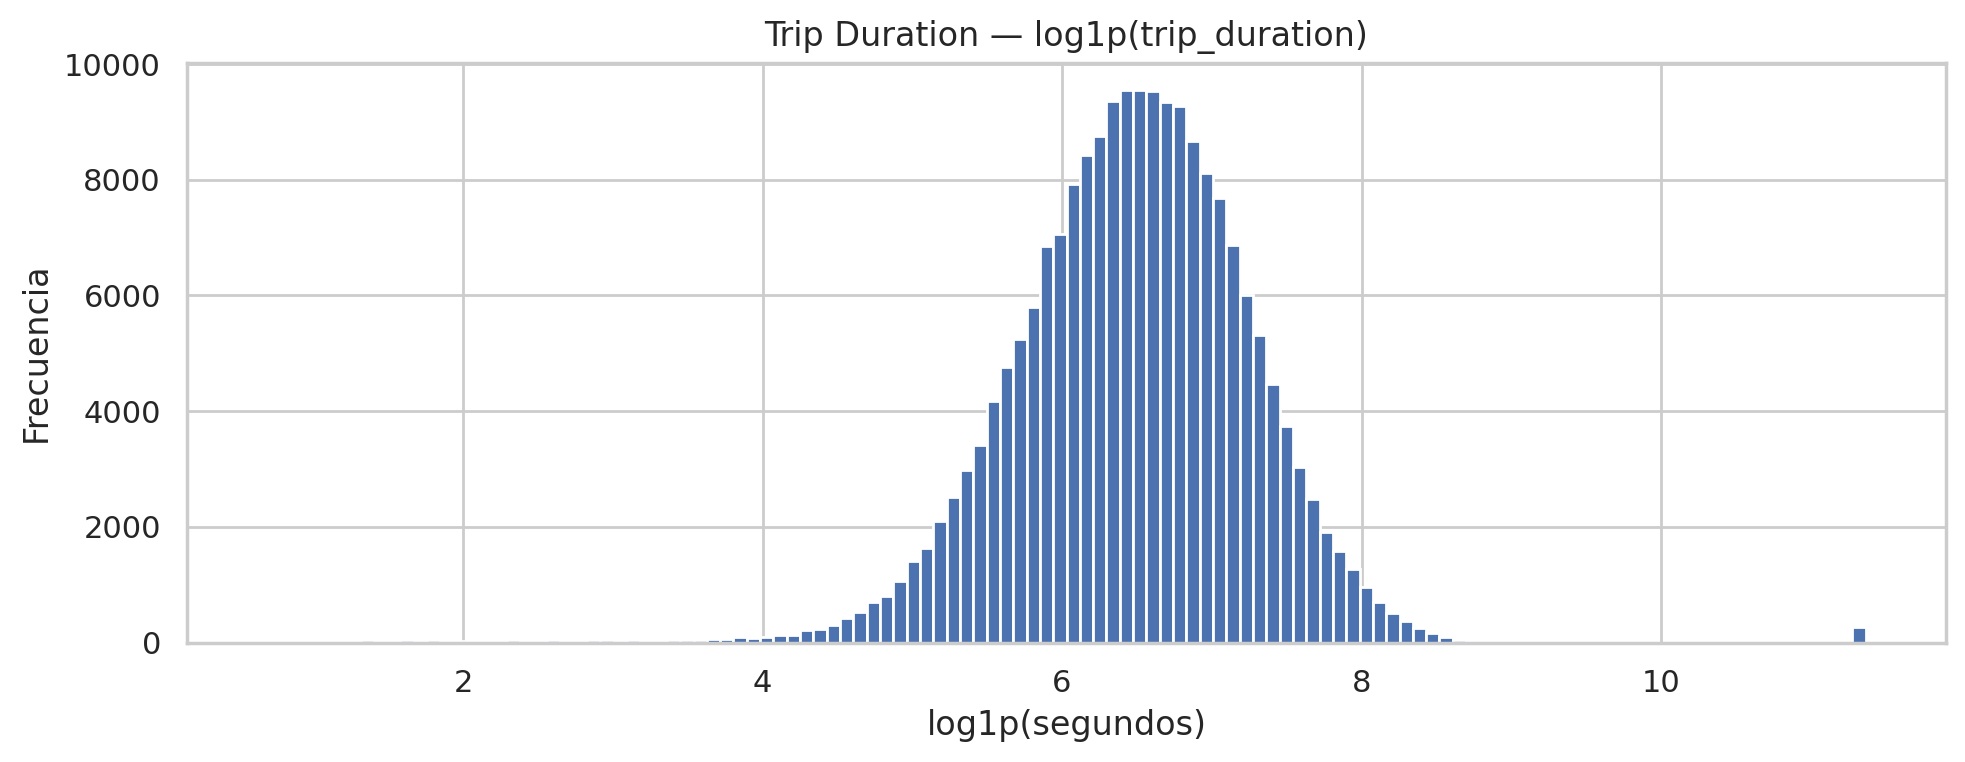

In [28]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(df_s["trip_duration_minutes"], bins=120)
ax.set_title("Trip Duration (min) — Distribución cruda (sesgada)")
ax.set_xlabel("Minutos")
ax.set_ylabel("Frecuencia")
plt.tight_layout()
plt.savefig(G_DIR / "01_hist_duracion_cruda.png", dpi=200)
plt.show()

fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(df_s["trip_duration_log"], bins=120)
ax.set_title("Trip Duration — log1p(trip_duration)")
ax.set_xlabel("log1p(segundos)")
ax.set_ylabel("Frecuencia")
plt.tight_layout()
plt.savefig(G_DIR / "02_hist_duracion_log.png", dpi=200)
plt.show()

### C2) ¿Cuándo ocurre la demanda? (heatmap Día vs Hora)

Creamos un heatmap de **conteo de viajes** por día de semana y hora.  
Esto revela picos de movilidad (horas punta) de forma inmediata.

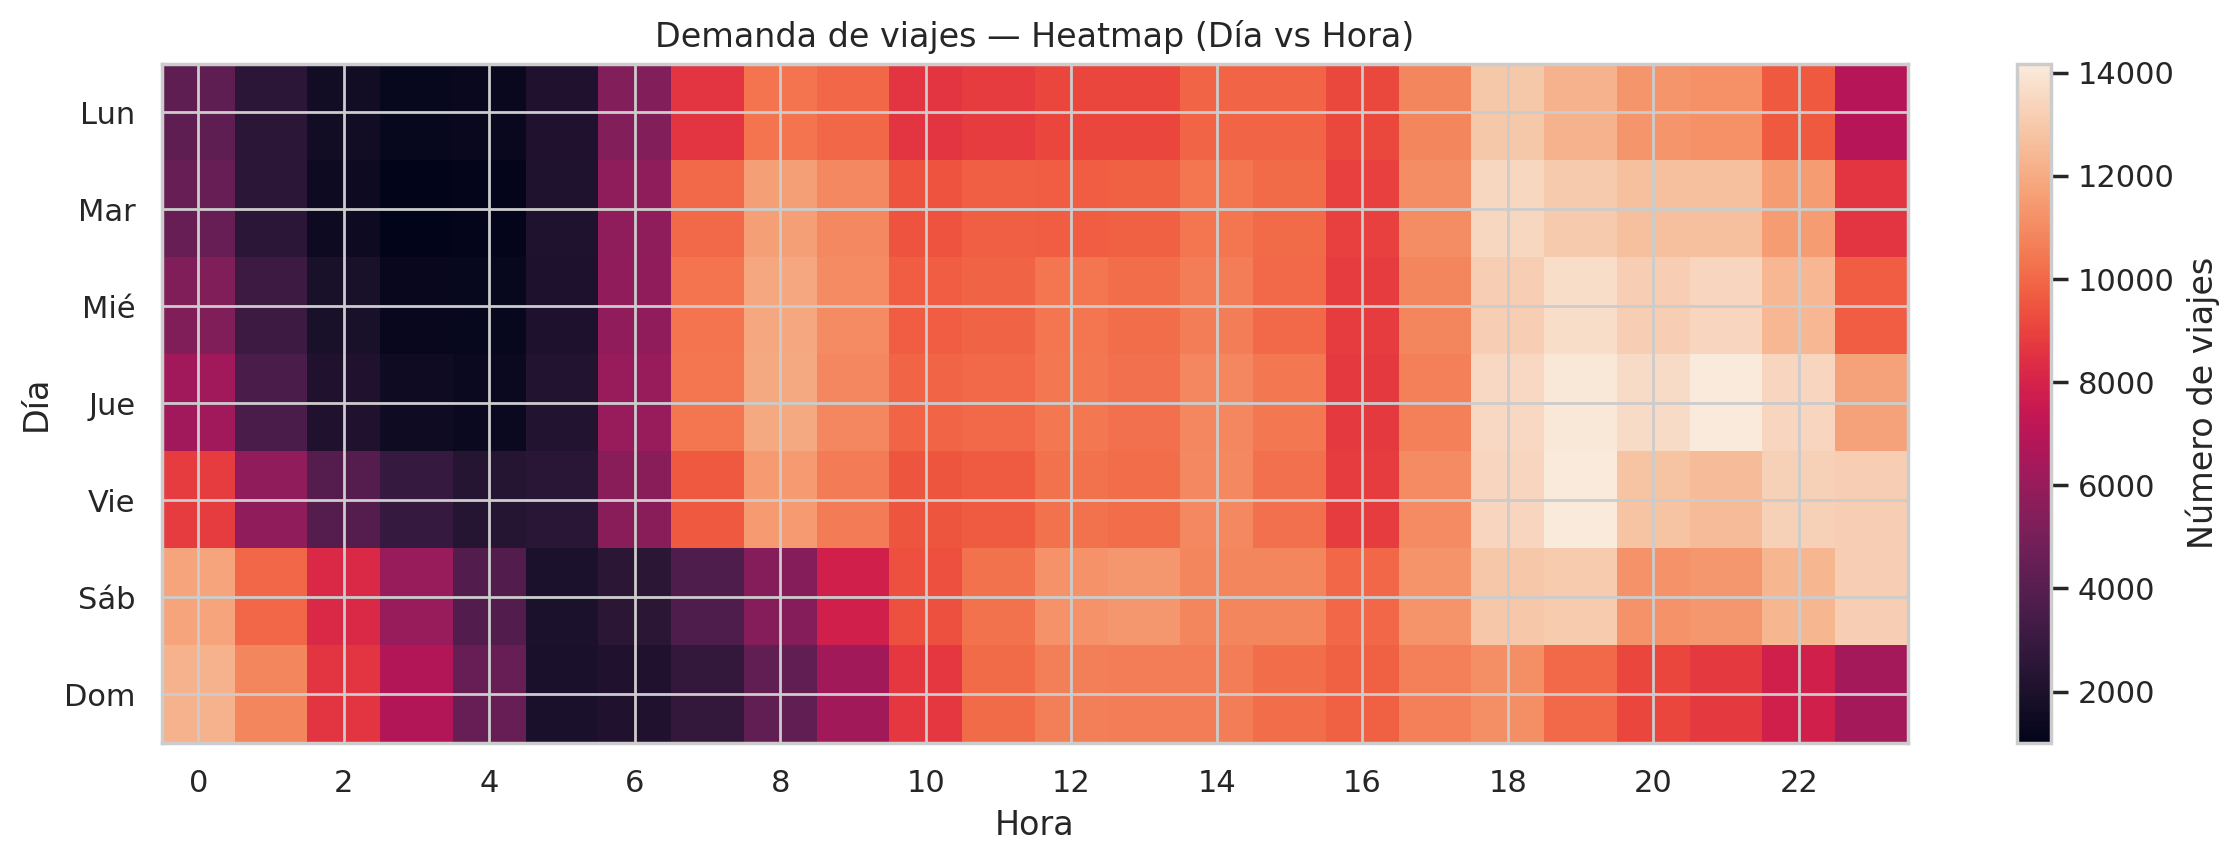

In [29]:
# Conteos (tabla pivote)
counts = (
    df.groupby(["pickup_dayofweek", "pickup_hour"])
      .size()
      .unstack(fill_value=0)
)

day_labels = ["Lun", "Mar", "Mié", "Jue", "Vie", "Sáb", "Dom"]
counts.index = [day_labels[i] for i in counts.index]

fig, ax = plt.subplots(figsize=(12, 4.5))
im = ax.imshow(counts.values, aspect="auto")
ax.set_title("Demanda de viajes — Heatmap (Día vs Hora)")
ax.set_xlabel("Hora")
ax.set_ylabel("Día")

ax.set_xticks(range(0, 24, 2))
ax.set_xticklabels(list(range(0, 24, 2)))
ax.set_yticks(range(len(counts.index)))
ax.set_yticklabels(counts.index)

plt.colorbar(im, ax=ax, label="Número de viajes")
plt.tight_layout()
plt.savefig(G_DIR / "03_heatmap_dia_hora.png", dpi=200)
plt.show()

### C3) ¿Cómo se relacionan distancia y duración? (ruido + outliers)

Relación esperada: a mayor distancia, mayor duración… pero no lineal (tráfico, rutas, paradas).  
Usamos `hexbin` para evitar overplotting y limitar outliers.

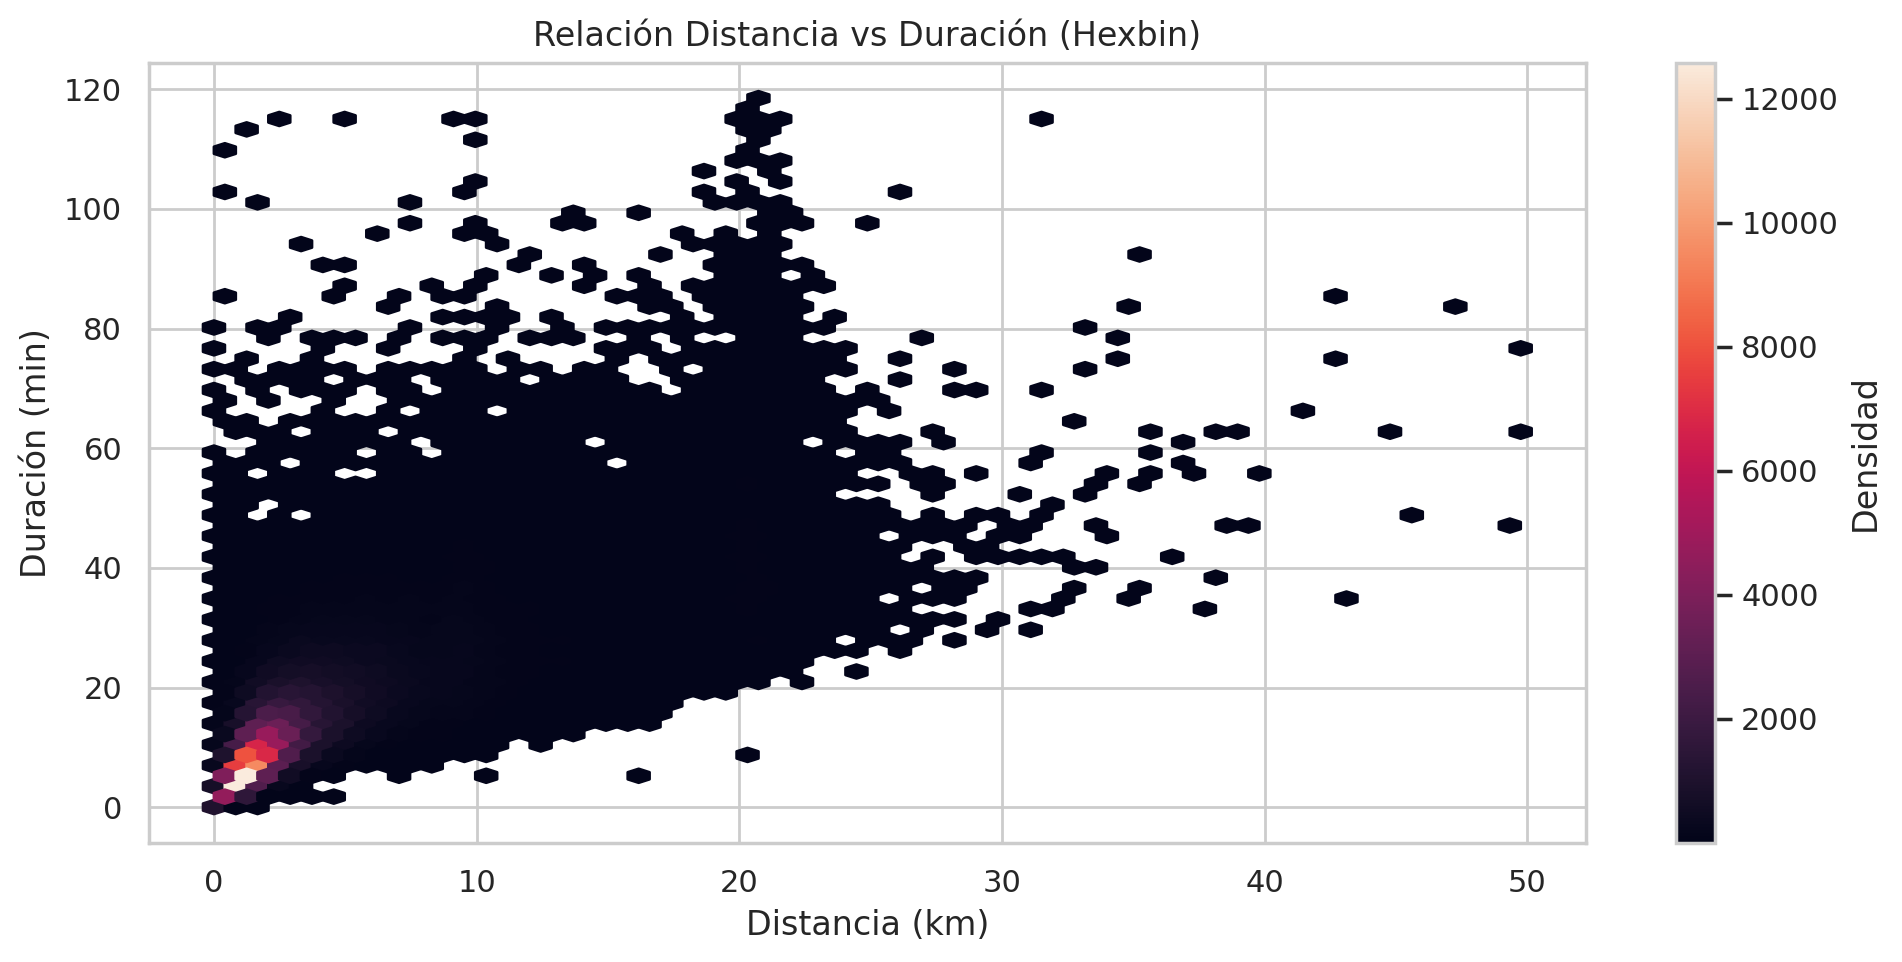

In [31]:
df_rel = df_s.copy()
# Limitar a rangos razonables para lectura (sin borrar data del dataset, solo para el gráfico)
df_rel = df_rel.query("distance_km.between(0, 50) and trip_duration_minutes.between(0, 120)")

fig, ax = plt.subplots(figsize=(10, 5))
hb = ax.hexbin(df_rel["distance_km"], df_rel["trip_duration_minutes"], gridsize=60, mincnt=1)
ax.set_title("Relación Distancia vs Duración (Hexbin)")
ax.set_xlabel("Distancia (km)")
ax.set_ylabel("Duración (min)")
plt.colorbar(hb, ax=ax, label="Densidad")
plt.tight_layout()
plt.savefig(G_DIR / "05_hexbin_dist_vs_dur.png", dpi=200)
plt.show()

### C4) Velocidad promedio por hora (proxy de congestión)

Calculamos la velocidad media aproximada por hora.  
Una caída sostenida en horas pico sugiere congestión.

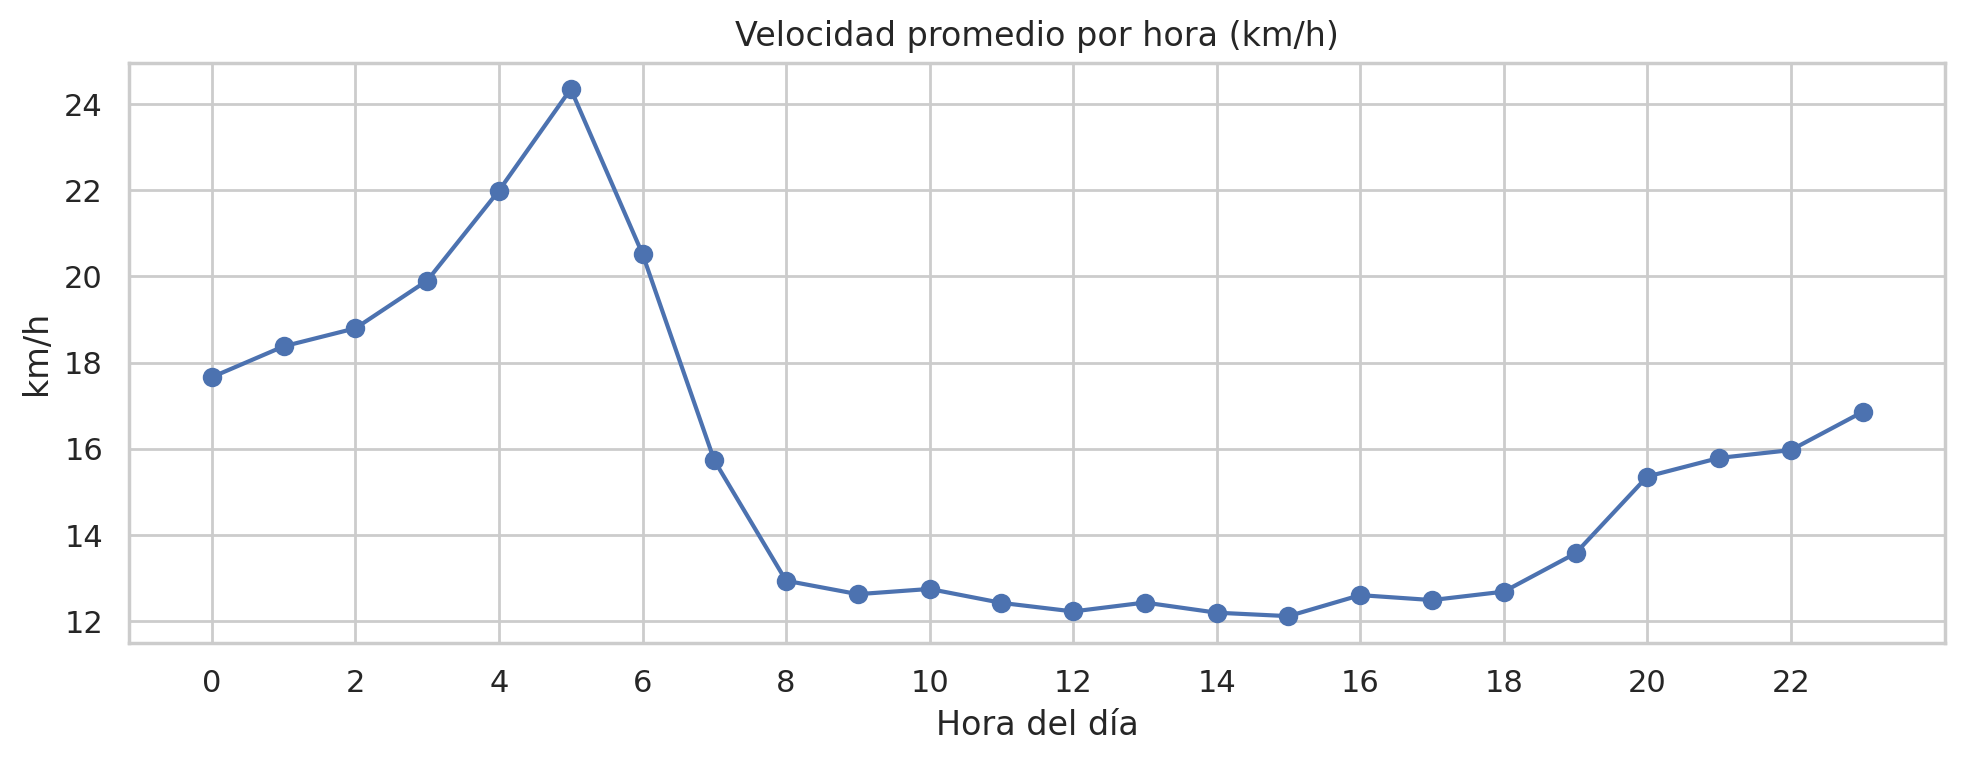

In [32]:
speed_by_hour = df.groupby("pickup_hour")["approx_speed_kmh"].mean()

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(speed_by_hour.index, speed_by_hour.values, marker="o")
ax.set_title("Velocidad promedio por hora (km/h)")
ax.set_xlabel("Hora del día")
ax.set_ylabel("km/h")
ax.set_xticks(range(0, 24, 2))
plt.tight_layout()
plt.savefig(G_DIR / "06_speed_by_hour.png", dpi=200)
plt.show()

## D) Capstone — Reporte PDF automático

El reporte incluye:
- Resumen de optimización (MB antes/después y % reducción)
- 3–5 hallazgos clave (métricas)
- Gráficos exportados (PNG) integrados al PDF

Esto simula una entrega real: **pipeline → insights → reporte**.

In [33]:
# =============================================================================
# D1) Métricas y hallazgos (ejemplo)
# =============================================================================
dias_semana = ["Lunes", "Martes", "Miércoles", "Jueves", "Viernes", "Sábado", "Domingo"]

hora_pico = int(df["pickup_hour"].value_counts().idxmax())
viajes_hora_pico = int(df["pickup_hour"].value_counts().max())

dia_mas_viajes_idx = int(df["pickup_dayofweek"].value_counts().idxmax())
dia_mas_viajes = dias_semana[dia_mas_viajes_idx]

duracion_media = float(df["trip_duration_minutes"].mean())
distancia_media = float(df["distance_km"].mean())
speed_media = float(df["approx_speed_kmh"].mean())

# Congestión proxy: velocidad horas pico vs valle
speed_pico = float(df[df["pickup_hour"].isin([8, 9, 17, 18, 19])]["approx_speed_kmh"].mean())
speed_valle = float(df[df["pickup_hour"].isin([2, 3, 4, 5])]["approx_speed_kmh"].mean())
impacto_trafico_pct = (speed_valle - speed_pico) / speed_valle * 100 if np.isfinite(speed_valle) and speed_valle != 0 else np.nan

dur_week = float(df[df["is_weekend"] == 0]["trip_duration_minutes"].mean())
dur_wend = float(df[df["is_weekend"] == 1]["trip_duration_minutes"].mean())
dif_weekend_pct = (dur_wend - dur_week) / dur_week * 100 if np.isfinite(dur_week) and dur_week != 0 else np.nan

print("Hora pico:", hora_pico, "viajes:", viajes_hora_pico)
print("Día con más viajes:", dia_mas_viajes)
print("Duración media (min):", round(duracion_media, 2))
print("Distancia media (km):", round(distancia_media, 2))
print("Velocidad media (km/h):", round(speed_media, 2))

Hora pico: 18 viajes: 90600
Día con más viajes: Viernes
Duración media (min): 15.99
Distancia media (km): 3.44
Velocidad media (km/h): 14.42


In [56]:
# =============================================================================
# D2) Generación del PDF con FPDF
# =============================================================================
from fpdf import FPDF
from pathlib import Path
from datetime import datetime

# === Rutas (según tu notebook) ===
OUT_DIR = Path("reportes")
G_DIR   = OUT_DIR / "graficos"
OUT_DIR.mkdir(exist_ok=True, parents=True)

pdf_path = OUT_DIR / "Reporte_NYC_Taxi_Reto2.pdf"

# === Fuente Unicode (evita error por —, •, tildes, etc.) ===
FONT_REG = Path("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf")
FONT_BOLD = Path("/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf")

USE_UNICODE_FONT = FONT_REG.exists() and FONT_BOLD.exists()

def safe_txt(s: str) -> str:
    """
    Fallback por si NO hay fuente unicode:
    reemplaza caracteres problemáticos para latin-1.
    """
    return (s.replace("—", "-")
             .replace("•", "-")
             .replace("“", '"').replace("”", '"')
             .replace("’", "'").replace("‘", "'"))

class ReportPDF(FPDF):
    def __init__(self):
        super().__init__()
        self.set_auto_page_break(auto=True, margin=15)

        if USE_UNICODE_FONT:
            self.add_font("DejaVu", "", str(FONT_REG), uni=True)
            self.add_font("DejaVu", "B", str(FONT_BOLD), uni=True)
            self.font_family_reg = ("DejaVu", "")
            self.font_family_bold = ("DejaVu", "B")
        else:
            self.font_family_reg = ("Arial", "")
            self.font_family_bold = ("Arial", "B")

    def _set_font_reg(self, size=11):
        fam, style = self.font_family_reg
        self.set_font(fam, style, size)

    def _set_font_bold(self, size=12):
        fam, style = self.font_family_bold
        self.set_font(fam, style, size)

    def header(self):
        title = "Reporte - NYC Taxi Trip Duration (Reto 2)"
        subtitle = f"Generado: {datetime.now().strftime('%Y-%m-%d %H:%M')}"
        if not USE_UNICODE_FONT:
            title, subtitle = safe_txt(title), safe_txt(subtitle)

        self._set_font_bold(14)
        self.cell(0, 8, title, ln=1, align="C")
        self._set_font_reg(9)
        self.cell(0, 6, subtitle, ln=1, align="C")
        self.ln(2)

    def footer(self):
        self.set_y(-12)
        self._set_font_reg(8)
        self.cell(0, 8, f"Página {self.page_no()}", align="C")

    def h1(self, text):
        if not USE_UNICODE_FONT:
            text = safe_txt(text)
        self._set_font_bold(13)
        self.multi_cell(0, 7, text)
        self.ln(1)

    def p(self, text):
        if not USE_UNICODE_FONT:
            text = safe_txt(text)
        self._set_font_reg(10)
        self.multi_cell(0, 5, text)
        self.ln(1)

    def metric_row(self, k, v):
        if not USE_UNICODE_FONT:
            k, v = safe_txt(k), safe_txt(v)
        self._set_font_bold(10)
        self.cell(55, 6, k)
        self._set_font_reg(10)
        self.cell(0, 6, v, ln=1)

    def add_plot_page(self, title, explanation, img_path: Path):
        self.add_page()
        self.h1(title)
        self.p(explanation)

        if img_path.exists():
            # Ajuste simple: ancho casi total, manteniendo márgenes
            self.image(str(img_path), x=10, w=190)
            self.ln(2)
        else:
            self.p(f"[WARN] No encontré la imagen: {img_path.name}")

# =========================
# 1) Construcción del PDF
# =========================
pdf = ReportPDF()

# --- PORTADA / RESUMEN EJECUTIVO ---
pdf.add_page()
pdf.h1("Resumen ejecutivo")
pdf.p(
    "Este reporte muestra un flujo completo de ingeniería de datos con Pandas sobre el dataset NYC Taxi "
    "(~1.4M filas). Se aplican técnicas de optimización de memoria (downcasting y category), "
    "ingeniería de variables vectorizada (tiempo y geoespacial), visualización con storytelling "
    "y generación automática de un reporte PDF para toma de decisiones."
)

# --- OPTIMIZACIÓN (usa tus variables ya calculadas) ---
pdf.h1("1) Optimización de memoria")
pdf.metric_row("Memoria antes:",  f"{mem_before_mb:,.2f} MB")
pdf.metric_row("Memoria después:", f"{mem_after_mb:,.2f} MB")
pdf.metric_row("Reducción:", f"{reduction_pct:,.1f}%")

pdf.p(
    "Decisiones técnicas:\n"
    "- Downcasting: int64 -> int8/int16/int32 según rangos reales.\n"
    "- Float64 -> float32 para coordenadas y métricas continuas.\n"
    "- Object -> category cuando la cardinalidad es baja (ej: store_and_fwd_flag).\n"
    "- Fechas a datetime para habilitar .dt y mejorar vectorización."
)

# --- HALLAZGOS (usa tus variables ya calculadas) ---
pdf.h1("2) Hallazgos clave (métricas)")
pdf.p(
    f"- Hora pico: {hora_pico}:00 (viajes: {viajes_hora_pico:,})\n"
    f"- Día con más viajes: {dia_mas_viajes}\n"
    f"- Duración media: {duracion_media:.2f} min\n"
    f"- Distancia media: {distancia_media:.2f} km\n"
    f"- Velocidad media: {speed_media:.2f} km/h\n"
    f"- Impacto del tráfico (pico vs valle): {impacto_trafico_pct:.1f}%\n"
    f"- Diferencia fin de semana: {dif_weekend_pct:+.1f}% (duración)"
)

pdf.p(
    "Interpretación rápida:\n"
    "Las métricas combinan demanda (volumen), tiempo (duración), espacio (distancia) y eficiencia (velocidad). "
    "Esto permite contar una historia operacional: cuándo hay más viajes, dónde se concentran y cómo cambia "
    "la movilidad a lo largo del día."
)

# --- PÁGINAS POR GRÁFICA (explicación + imagen) ---
plots_info = [
    (
        "3) Distribución de duración (cruda)",
        "Esta gráfica suele verse extremadamente sesgada: la mayoría de viajes dura pocos minutos y existe una cola larga "
        "de viajes muy grandes (posibles outliers, errores de registro o casos raros). "
        "Sirve para justificar por qué una escala normal no permite ver bien el comportamiento típico.",
        G_DIR / "01_hist_duracion_cruda.png",
    ),
    (
        "4) Distribución de duración (transformación log)",
        "Aplicar log1p(duración) comprime la cola larga y revela mejor la forma central de la distribución. "
        "Esto facilita comparar patrones, detectar anomalías y construir modelos o reglas de negocio sin que los outliers dominen.",
        G_DIR / "02_hist_duracion_log.png",
    ),
    (
        "5) Demanda por día y hora (heatmap)",
        "El heatmap muestra concentración de viajes por hora y día. Normalmente aparecen 'horas pico' (mañana y tarde) "
        "en días laborales, y patrones distintos en fin de semana. "
        "Es útil para decisiones de operación: turnos, oferta y planificación.",
        G_DIR / "03_heatmap_dia_hora.png",
    ),
    (
        "6) Densidad geoespacial (hexbin)",
        "El hexbin resuelve el overplotting: con millones de puntos, un scatter se vuelve una mancha. "
        "Aquí cada hexágono agrega cantidad de pickups en esa zona. Zonas más claras = más demanda. "
        "Esto permite identificar hotspots (ej. Manhattan) y áreas de baja demanda.",
        G_DIR / "04_hexbin_pickups.png",  # si no existe, te lo marca como WARN
    ),
    (
        "7) Velocidad promedio por hora",
        "Esta curva cuenta la historia del tráfico: en horas pico la velocidad cae (congestión), "
        "y en la madrugada sube (calles despejadas). "
        "Es una visual clave para medir eficiencia y estimar tiempos esperados.",
        G_DIR / "06_speed_by_hour.png",
    ),
]

for title, explanation, img in plots_info:
    pdf.add_plot_page(title, explanation, img)

# Guardar
pdf.output(str(pdf_path))
pdf_path


PosixPath('reportes/Reporte_NYC_Taxi_Reto2.pdf')

## ✅ Conclusiones

En este reto demostramos prácticas profesionales de ingeniería de datos con Pandas:

1. **Optimización de recursos:** reducción de memoria con tipos correctos (target ≥50%).
2. **Vectorización:** features temporales, duraciones y Haversine sin loops por fila.
3. **Storytelling:** visualizaciones que explican demanda, geografía y congestión.
4. **Automatización:** generación de un reporte PDF consumible por negocio.